# NLP - M2 MAS

## Maël Mandard - Ewen Le Cunff

Notre projet de NLP se base sur des données récupérées sur l'API de la cour de cassation. Nous avons choisi les données correspondant à la formation et à la rupture de contrat de travail. Nous avons 500 textes pour chaque catégorie. 
Nous allons nous demander à quelle précision pourrons-nous classifier les textes juridiques dans nos deux catégories (formation et rupture de contrat de travail). Ensuite nous nous demanderons quels sont les thématiques qui ressortent le plus souvent de tous ces textes en ne prenant pas en compte les deux catégories de base.

### SOMMAIRE

1. Chargement des librairies
2. Chargement de données
3. Définitions de fonctions
4. Préparation / Nettoyage des données
5. Visualisation des données
6. Analyse des documents
7. Classification des documents
8. LDA (Latent Dirichlet Allocation)

#### Chargement des librairies

In [1]:
import json
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from prince import MCA
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


#### Chargement des données

In [2]:
liste = ['formation0', 'formation1', 'formation2', 'formation3', 'formation4',
         'rupture0', 'rupture1', 'rupture2', 'rupture3', 'rupture4']

date = []
texte = []
theme = []

for obj in liste :
    #f = open(f"C:/Users/Mael/Documents/Fac/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    f = open(f"C:/Users/ewen/Documents/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    
    data = json.load(f)
    
    them = data['query']['theme']
    
    results = data['results']
    
    for res in results : 
        theme.append(them[0])
        date.append(res['decision_date'])
        texte.append(res['text'])
    

fin_data = pd.DataFrame({'date' : date, 'theme' : theme, 'texte' : texte})

Nous chargeons les données dans un DataFrame en enregistrant la date, le thème et le texte du document que nous allons analyser.

#### Définition de fonctions

In [3]:
# Fonction qui permet d'afficher les graphiques lors de l'analyse de thématiques
def plot_top_words(model, feature_names, n_top_words, title, lda_components):
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index, topic in enumerate(lda_components):
        top_features_key = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_key]
        weights = topic[top_features_key]
        
        ax = axes[index]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {index +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.1, wspace=0.50, hspace=0.25)
    plt.show()

#### Préparation/Nettoyage de données

Nous faisons une extraction des entités nommées (noms de personnes, d'organisations, de lieux) car ce ne sont pas des données intéressantes pour notre analyse.

In [4]:
nlp = spacy.load('fr_core_news_sm')

def remove_named_entities(text):
    doc = nlp(text)
    new_tokens = (token.text for token in doc if token.ent_type_ == '')
    return ' '.join(new_tokens)

fin_data['text-entite-nommee'] = fin_data['texte'].apply(lambda x: remove_named_entities(x))

Ensuite nous mettons le texte en minuscule.

In [5]:
def mise_en_minuscule(text):
    return text.replace(text, text.lower())

fin_data['texte_propre'] = fin_data['text-entite-nommee'].apply(lambda x: mise_en_minuscule(x))

Nous supprimons tous les accents.

In [6]:
def remove_accents(text) : 
    return unidecode(text)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: remove_accents(x))

Nous nettoyons ensuite le texte, c'est à dire qu'on remplace les caractères non alphanumériques en espace pour éviter les problèmes avec les "l'", "n'", etc... . Nous nettoyons les mots qui contiennent un chiffre et les mots qui contiennent une seule lettre.

In [7]:
def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) #supprimer les caractères non alphanumériques
    text = re.sub(r'\b\d+\b', '', text) #supprimer les mots qui contiennent un chiffre
    text = re.sub(r'\b\w\b', '', text) #supprimer les mots qui contiennent une seule lettre
    return text

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: clean_text(x))

Par la suite nous supprimons les stopwords. Les stopwords sont téléchargés grâce à la librairie nltk, nous ajoutons à la liste, des mots à la main car la liste de mots vides n'était pas complète pour nous.

In [8]:
from nltk.tokenize import word_tokenize

def supprime_stopwords(text, stop_words, rare_threshold=0.2):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
liste_stop = ['apos', 'meme', 'sans', 'ni', 'lors', 'etre', 'eter', 'cour', 'faire', 'ete', 'non', 'moyen', 'pouvoir', 'avoir', 'plus', 'etant', 
              'article', 'salarie', 'contrat', 'arret', 'code', 'travail', 'societe', 'employeur', 'appel', 
              'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'decembre',
              'celui', 'celle', 'cette', 'ainsi', 'donc', 'dont', 'si', 'ci', 'etait', 'part', 'tout', 'alors', 'mois', 'selon',
              'apre', 'deux', 'date', 'party', 'lequel', 'mettre', 'comme', 'deg']
#              'soc', 'cds', 'peuple', 'fs', 'audience', 'mm', 'mme', 'mr', 'monsieur', 
#              'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'decembre', 
#              'dont', 'alors', 'lors', 'meme', 'apos', 'ni', 'non', 'deg',
#              'celui', 'ci', 'celle', 'cette', 'ete', 'peut', 'ndeg', 'si', 'donc', 'ainsi', 'tout', 'etre', 'sans',
#              'travail', 'salarie', 'cour', 'employeur', 'article', 'code', 'appel', 'avoir',
#              'societe', 'contrat', 'arret', 'faire', 'moyen', 'etais', 'etait']
stop_words.update(liste_stop)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_stopwords(x, stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On supprime les espaces mutliples dans notre texte car lorsqu'on supprime un mot c'est possible d'avoir plusieurs espaces d'affilé.

In [9]:
def supprime_espace(text):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word]
    return ' '.join(filtered_words)

fin_data['texte_propre'] = fin_data['texte_propre'].apply(lambda x: supprime_espace(x))

Pour finir on lemmatise les mots de nos textes pour regrouper les mots de la même famille et donc avoir une simplification du texte pour réaliser une meilleure analyse.

In [10]:
def lemmatisation(text, stop_words):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    return ' '.join(lemmatized_tokens)

fin_data['texte_lemma'] = fin_data['texte_propre'].apply(lambda x: lemmatisation(x, stop_words))

#### Visualisation des données

Création d'un nuage de mots pour voir une visualisation des mots ou expression les plus utilisées dans les textes juridiques.
Nous faisons ce nuage de mots avec les données nettoyées mais pas lemmatisées pour avoir plus de réalité dans les mots qui s'affichent. 

On remarque ici dans le nuage de mots que les mots/expressions suivantes sont les plus utilisées :

1. Dommage interêt 
2. Fait grief
3. Salariée

Nous retrouvons aussi en plus petit des expressions comme :

1. Convention collective
2. Motif économique
3. Période d'essai 
4. Procédure civile
5. Congés payé
6. Licenciement cause

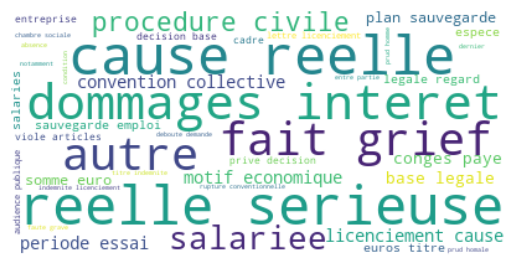

In [11]:
wordcloud = WordCloud(background_color="white", max_words = 40)
text = " ".join(fin_data['texte_propre'].tolist()) 
wordcloud.generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Analyse des documents

Création de la matrice document-terme, c'est une matrice qui montre la fréquence des termes qui apparaissent dans les documents.

In [12]:
vec = CountVectorizer()
X_doc_terme = vec.fit_transform(fin_data['texte_lemma'])

Nous visualisons ici les termes les plus utilisés dans les 1000 documents. Les 3 termes les plus utilisés sont : "licenciement", "demande", "indemnité".

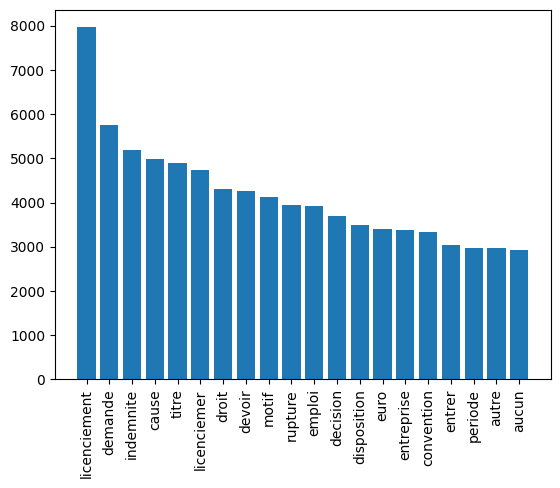

In [13]:
freqs = [(word, X_doc_terme.getcol(idx).sum()) for word, idx in vec.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.show()

Création de la matrice TF-IDF, cette mesure permet d'évaluer l'importance d'un terme contenu dans un document. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [14]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(fin_data['texte_lemma'])

Visualisation du TF-IDF

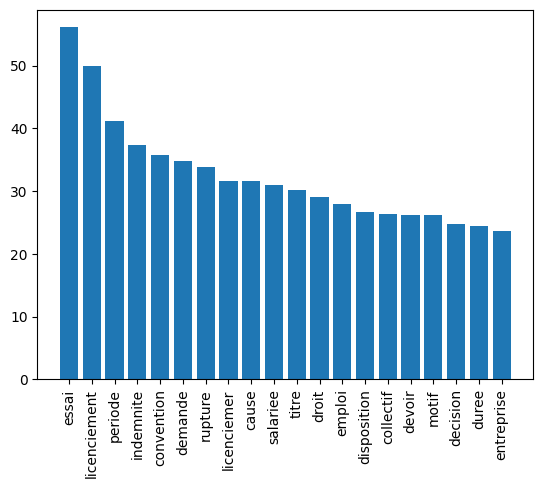

In [15]:
freqs = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
freqs = sorted(freqs, key=lambda x: -x[1])

plt.bar([x[0] for x in freqs[:20]], [x[1] for x in freqs[:20]])
plt.xticks(rotation=90)
plt.show()

#### Classification des documents

Création d'une colonne : le document aura comme valeur "0" si il correspond au thème de la rupture de contrat de travail et prendra comme valeur "1" sinon.

In [16]:
fin_data["theme_bin"] = fin_data["theme"].apply(lambda x: 0 if x == 'contrat de travail, rupture' else 1)

df_X_doc_terme = pd.DataFrame(X_doc_terme.toarray(), columns=vec.get_feature_names_out())
df_X_doc_terme_theme = pd.concat([df_X_doc_terme, fin_data['theme_bin']], axis=1)

Nous séparons le jeu de données en deux groupes : un groupe de "train" pour entraîner l'algorithme et un groupe de "test" pour évaluer les performances de celui-ci.

In [17]:
X = df_X_doc_terme
y = fin_data["theme_bin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

Pour optimiser les paramètres d'une forêt aléatoire, nous faisons une grille de paramètres à tester puis nous lançons la modélisation. Nous avons en sortie les meilleurs paramètres pour notre forêt aléatoire.

In [18]:
# Random Forest
rf = RandomForestClassifier()

# Réalisation d'une grille de paramètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Utilisation de la grille de paramètres
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)

KeyboardInterrupt: 

Nous avons donc récupérés les paramètres optimaux pour notre forêt aléatoire. Nous les utilisons, et nous nous concentrons sur la mesure "accuracy", c'est le taux de bons classement. Ici nous avons 94% de précision.

In [19]:
forest = RandomForestClassifier(criterion='gini',
                                 max_depth=10,
                                 min_samples_split=10,
                                 n_estimators=50)

# Entrainement du modèle
forest.fit(X_train, y_train)
 
# Mesure de la performance
y_pred = forest.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.944


#### LDA (Latent Dirichlet Allocation)

In [27]:
from sklearn.decomposition import LatentDirichletAllocation

lda_doc_terme = LatentDirichletAllocation(n_components=5, random_state=1234)
lda_matrix_doc_terme = lda_doc_terme.fit_transform(X_doc_terme)

terms_doc_terme = vec.get_feature_names_out()

lda_components_doc_terme=lda_doc_terme.components_

for index, component in enumerate(lda_components_doc_terme):
    zipped = zip(terms_doc_terme, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['periode', 'essai', 'demande', 'fonction', 'disposition', 'droit']
Topic 1:  ['licenciement', 'cause', 'licenciemer', 'faute', 'demande', 'fait']
Topic 2:  ['indemnite', 'titre', 'euro', 'demande', 'salair', 'heure']
Topic 3:  ['licenciement', 'emploi', 'economiqu', 'motif', 'plan', 'cause']
Topic 4:  ['convention', 'rupture', 'indemnite', 'conventionnel', 'ruptur', 'disposition']


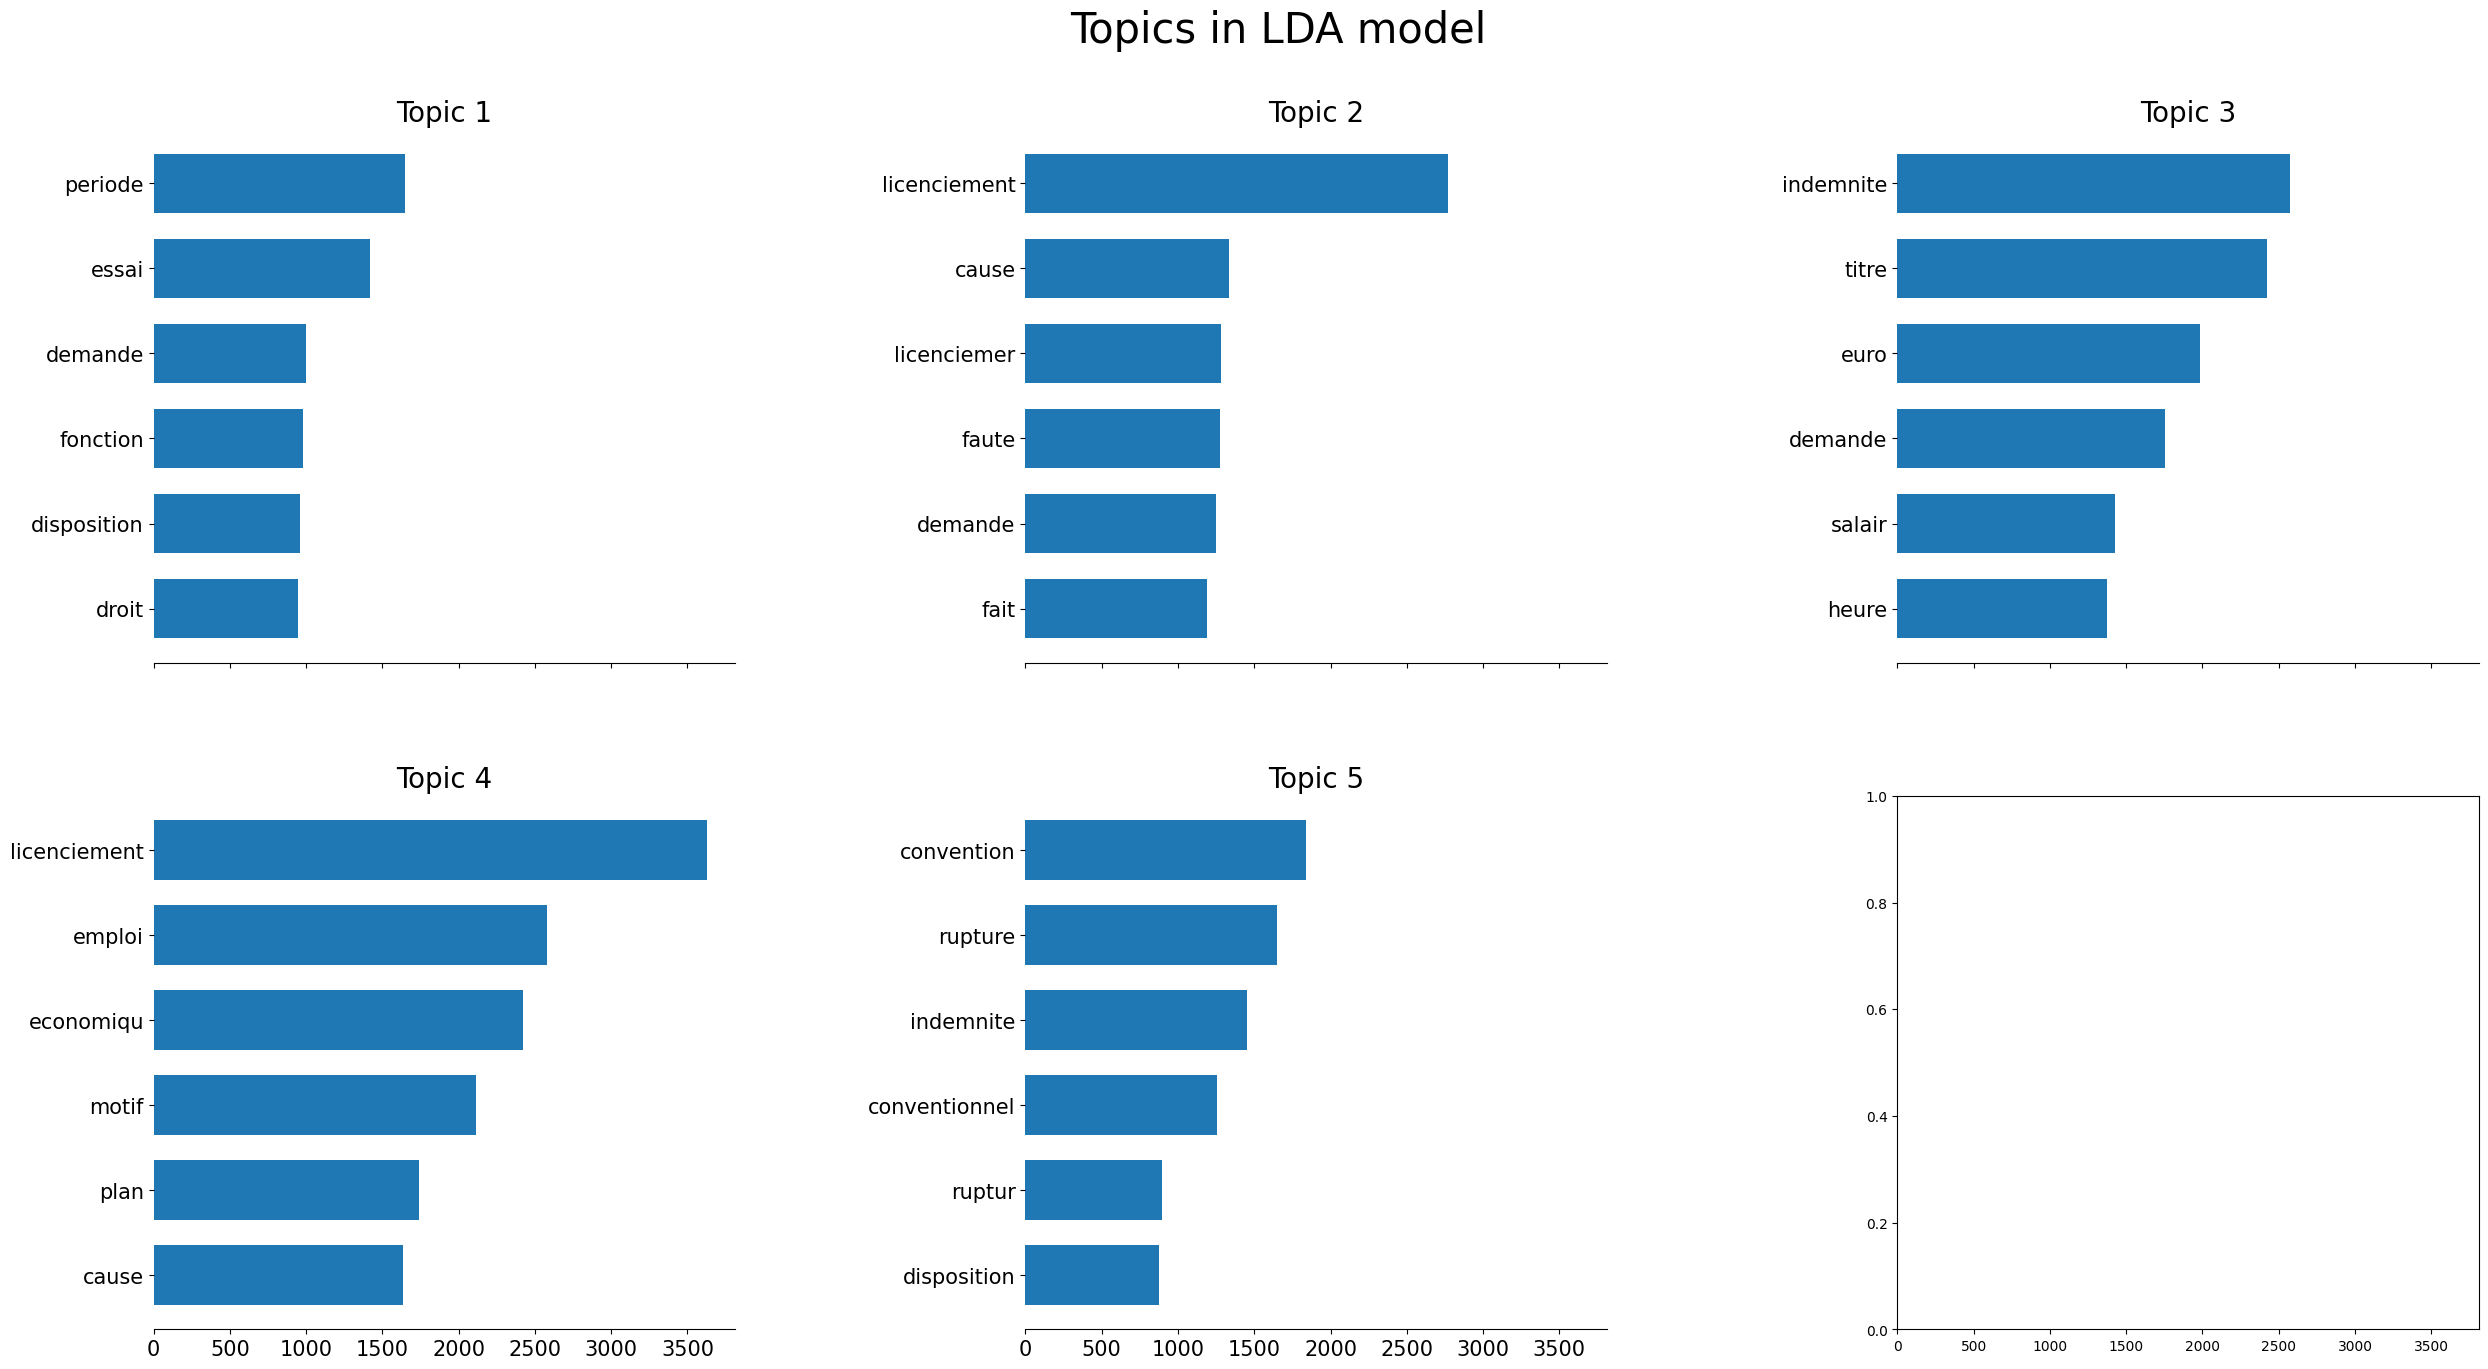

In [28]:
n_top_words = 6
plot_top_words(lda_doc_terme, terms_doc_terme, n_top_words, "Topics in LDA model", lda_components_doc_terme)

A REVOIR 
Avec matrice document-termes :
1) Tout se qui touche à la période d'essai (demande, rupture)
2) Licenciement économique de la part de l'entreprise
3) Demande de licenciement du salarié pour raison personnelle (cause, motif)
4) Demande de rupture conventionnelle
5) Ne sais pas
6) Tout le domaine qui tourne autour de l'argent (indemnité, salaire, montant, euro)

In [34]:
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=1234)
lda_matrix_tfidf = lda_tfidf.fit_transform(X_tfidf)

terms_tfidf = vectorizer.get_feature_names_out()

lda_components_tfidf=lda_tfidf.components_

for index, component in enumerate(lda_components_tfidf):
    zipped = zip(terms_tfidf, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ", top_terms_list)

Topic 0:  ['essai', 'licenciement', 'periode', 'indemnite', 'convention', 'demande', 'rupture', 'licenciemer', 'cause', 'salariee']
Topic 1:  ['joueur', 'createur', 'costume', 'rugby', 'decorateur', 'boucle', 'keyria', 'entrainement', 'club', 'costumier']
Topic 2:  ['houssage', 'inspire', 'dessinee', 'bande', 'paleter', 'colorist', 'applicabler', 'troisiem', 'roman', 'dessine']
Topic 3:  ['pasteur', 'erf', 'theologie', 'cultuel', 'ordination', 'populaire', 'pastoral', 'consecration', 'histoire', 'synodal']
Topic 4:  ['nicoroi', 'vaccination', 'kali', 'artifice', 'hepatite', 'sage', 'funebre', 'pompe', 'exploite', 'stylo']


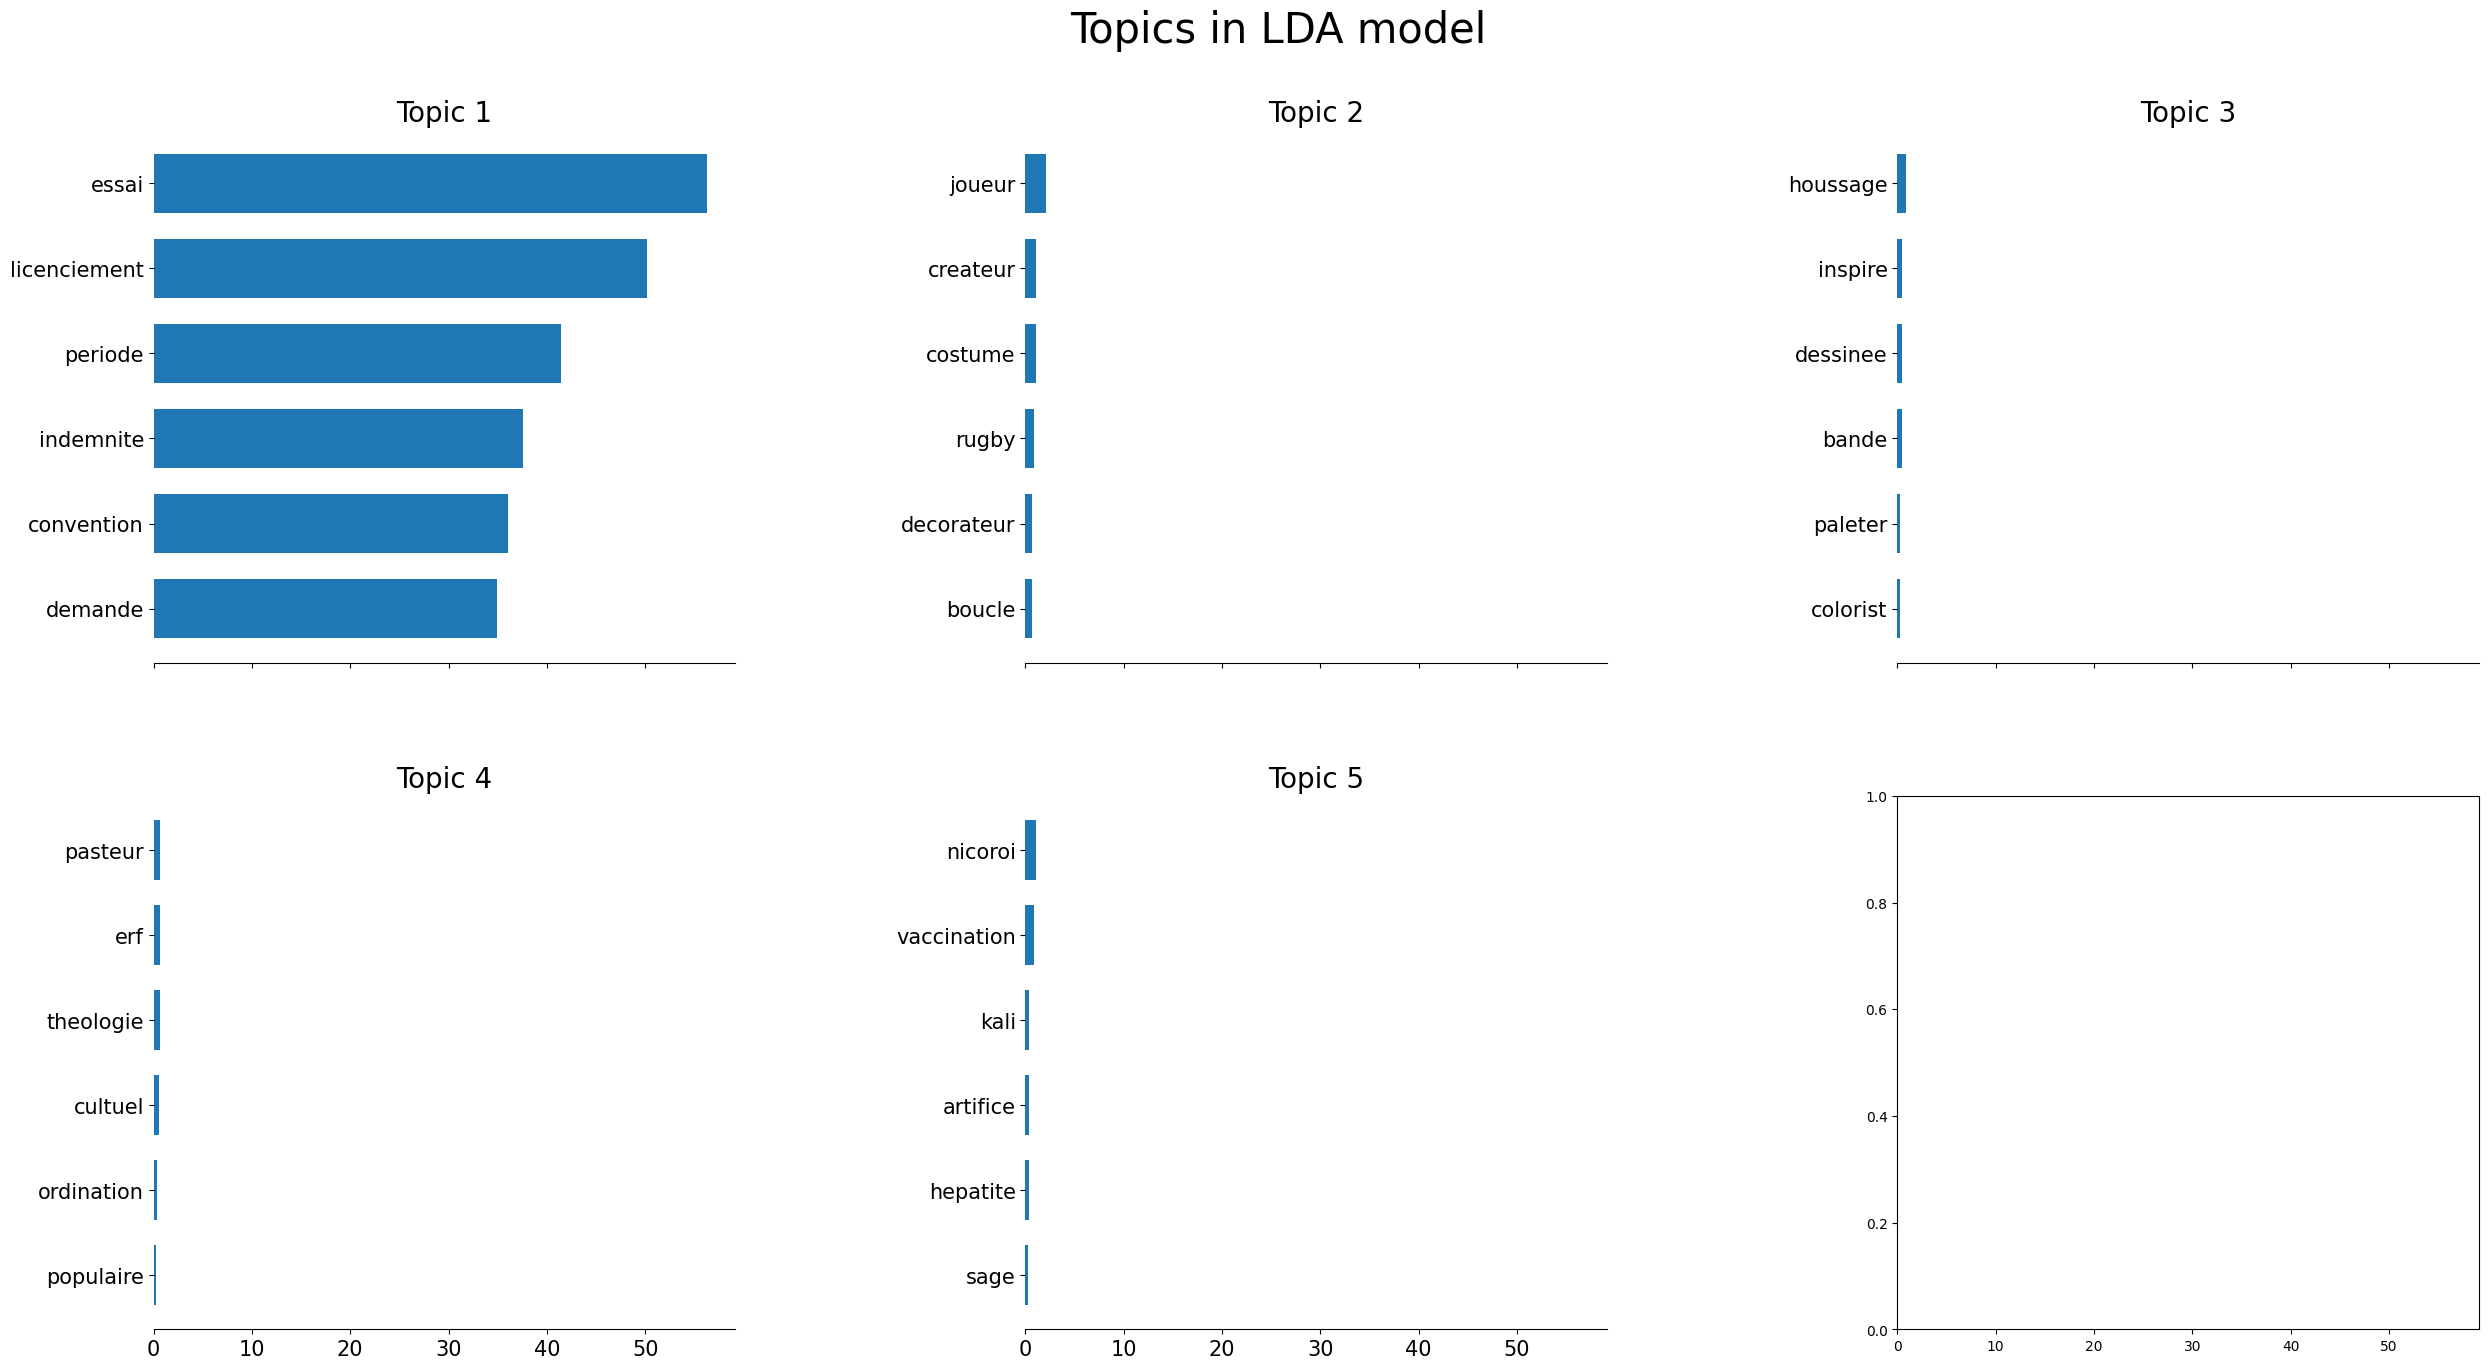

In [35]:
plot_top_words(lda_tfidf, terms_tfidf, n_top_words, "Topics in LDA model", lda_components_tfidf)

Avec matrice tf-idf :
1) Une grande classe, les autres sont pas représentatives

#### NMF

Détection de thématiques

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [95]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
X = vectorizer.fit_transform(fin_data["texte_lemma"])

In [98]:
vectorizer = CountVectorizer(max_df=0.5, min_df=2)
X = vectorizer.fit_transform(fin_data['texte_lemma'])

In [ ]:
num_topics = 5 # définir le nombre de sujets à extraire
nmf = NMF(n_components=num_topics, random_state=1)
nmf.fit(X)

In [ ]:
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
    print()

In [34]:
fin_data["topic"] = nmf.transform(X).argmax(axis=1)

In [ ]:
fig, ax = plt.subplots()
colors = ["red", "green", "blue", "orange", "purple"]
for i in range(num_topics):
    ax.scatter(X[fin_data["topic"] == i, 0].toarray(), X[fin_data["topic"] == i, 1].toarray(), c=colors[i], label="Topic %d" % i, alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()